# Small networks plot


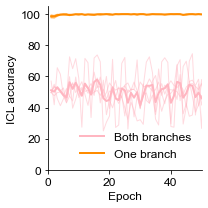

In [67]:
# Import necessary components
import torch

# Import from refactored modular structure
from data_generation import GaussianMixtureModel, generate_icl_gmm_data
from datasets import ICLGMMDataset, collate_fn
from models import MatrixTreeMarkovICL
from training import train_model
from evaluation import test_icl

from torch.utils.data import DataLoader
import os
import time

import pickle
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Arial'
import numpy as np


seed_vals = [1,2,3,4,5]
# Plot training history
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
fs = 12

# Plot 1: Loss curves

epochs = range(1, 1001)

sub_alpha = 0.5

color = 'lightpink'
icl_avs = np.zeros(len(epochs))
for seed in seed_vals:
    path = f"/Users/csfloyd/Dropbox/Projects/MarkovComputation/DirsICL/n_nodes_seed_3_nobase2/2_{seed}/"
    # Load the results
    results_path = path + "results.pkl"
    with open(results_path, "rb") as file:
        data = pickle.load(file)

    # Extract components
    results = data['results']
    history = data['history']
    params = data['params']
    execution_time = data['execution_time']


    icl_acc = np.array(history['icl_acc'])
    ax.plot(epochs, icl_acc, linewidth=1, color = color, alpha = sub_alpha)
    icl_avs += icl_acc
icl_avs /= len(seed_vals)
ax.plot(epochs, icl_avs, linewidth=2, color = color, label = 'Both branches')

color = 'darkorange'
icl_avs = np.zeros(len(epochs))
for seed in seed_vals:
    path = f"/Users/csfloyd/Dropbox/Projects/MarkovComputation/DirsICL/n_nodes_seed_3_max_nobase/2_{seed}/"
    # Load the results
    results_path = path + "results.pkl"
    with open(results_path, "rb") as file:
        data = pickle.load(file)

    # Extract components
    results = data['results']
    history = data['history']
    params = data['params']
    execution_time = data['execution_time']


    icl_acc = np.array(history['icl_acc'])
    ax.plot(epochs, icl_acc,  linewidth=1, color = color, alpha = sub_alpha)
    icl_avs += icl_acc
icl_avs /= len(seed_vals)
ax.plot(epochs, icl_avs, linewidth=2, color = color, label = 'One branch')






#ax.axhline(y=100, color='black', linestyle='--', linewidth=2, alpha=0.5, zorder = -10)

ax.set_xlabel('Epoch', fontsize=fs)
ax.set_ylabel('ICL accuracy', fontsize=fs)
ax.tick_params(axis='x', labelsize=fs)
ax.tick_params(axis='y', labelsize=fs)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim(0, 105)
ax.set_xlim(0, 50)
#ax.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
ax.grid(False)#, alpha=0.3)
ax.legend(fontsize=fs, frameon=False, loc='lower right', ncol=1)

plt.tight_layout()
plt.show()
# Save the figure in high resolution
save_path = '/Users/csfloyd/Dropbox/Projects/MarkovComputation/Figures/'
fig.savefig(save_path + 'ICLAccuracyTwoNodes.png', dpi=300, bbox_inches='tight')




  Initialized ICL Attention model (L=128 classes, attention over 2 context items)
  Label modulation: False
  Base rates learnable: True
  Base mask value: 0.0
  Sparsity K: rho_edge=1.000, rho_all=1.000
  Sparsity base_W: rho_edge=1.000
  K_params sparsity: 0.000 (12/12 active)
  base_W sparsity: 0.000 (4/4 active)
  Parameters: 20


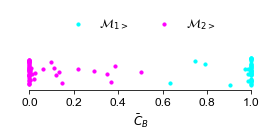

In [70]:
import ternary
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Arial'
import matplotlib.colors as mcolors
import pickle
# Import from refactored modular structure
from data_generation import GaussianMixtureModel, generate_icl_gmm_data
from datasets import ICLGMMDataset, collate_fn
from models import MatrixTreeMarkovICL
from training import train_model
from evaluation import test_icl
import torch
import random
from torch.utils.data import DataLoader

#path = "/Users/csfloyd/Dropbox/Projects/MarkovComputation/DirsICL/n_nodes_seed_3_nobase2/2_5/"
path = "/Users/csfloyd/Dropbox/Projects/MarkovComputation/DirsICL/n_nodes_seed_3_max_nobase2/2_4/"

seed = 5
random.seed(seed)

# Load the results
results_path = path + "results.pkl"
with open(results_path, "rb") as file:
    data = pickle.load(file)

# Extract components
results = data['results']
history = data['history']
params = data['params']
execution_time = data['execution_time']

# Assuming you have the model parameters
model = MatrixTreeMarkovICL(
    n_nodes=params['n_nodes'], 
    z_dim=params['D'], 
    L=params['L'], 
    N=params['N']
)

# Load the saved weights
model_path = path + 'model.pt'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.load_state_dict(torch.load(model_path, map_location=device))

model.to(device)
model.eval()

gmm = GaussianMixtureModel(
    K=params['K'], 
    D=params['D'], 
    L=params['L'], 
    epsilon=params['epsilon'], 
    seed=params['seed'], 
    offset=params['offset']
)

train_data = generate_icl_gmm_data(gmm, params['train_samples'], params['N'], 
                                   novel_classes=False, exact_copy=params['exact_copy'], 
                                   B=params['B'], L=params['L'], shuffle_context=params['shuffle_context'], min_max_choice=params['min_max_choice'], unique_labels = params['unique_labels'])

train_loader = DataLoader(ICLGMMDataset(train_data), batch_size=params['batch_size'],
                          shuffle=True, collate_fn=collate_fn)





# Loop to collect n_samples points
n_samples = 100
p_steady_list = []
targets_list = []
class_list = []
min_max_list = []
model.eval()
with torch.no_grad():
    for i in range(n_samples):
        # Get a single example from the training dataset
        z_seq, labels, targets = train_loader.dataset[i]
        
        # Add batch dimension and move to device
        z_seq = z_seq.unsqueeze(0).to(device)  # Shape: (1, N+1, D)
        labels = labels.unsqueeze(0).to(device)  # Shape: (1, N)
        targets = targets.unsqueeze(0).to(device).long()  # Shape: (1,)
        # print(targets)
        # print(labels)
        # Find which element of labels equals the target
        matching_indices = (labels[0] == targets[0]).nonzero(as_tuple=True)[0]
        if len(matching_indices) > 0:
            class_idx = matching_indices[0].item()
        else:
            class_idx = -1  # No matching class found
        class_list.append(class_idx)
        
        # Flatten z_seq as the model expects
        z_flat = z_seq.reshape(1, -1)  # Shape: (1, (N+1)*D)
        
        # Compute the rate matrix K
        W_mat = model.compute_rate_matrix_W(z_flat)
        p_steady = model.direct_solve_steady_state(W_mat)  # default

        z_array = np.array(z_flat)[0]
        # if np.max(np.array(p_steady)) <= 0.6:
        #     print(z_array)

        if z_array[class_idx] > z_array[1-class_idx]:
            min_max_list.append(1)
        else:
            min_max_list.append(0)

        # Store results
        p_steady_list.append(p_steady.cpu())
        targets_list.append(targets.cpu())

# Convert lists to tensors for easier manipulation
p_steady_all = torch.cat(p_steady_list, dim=0)  # Shape: (n_samples, n_nodes)
targets_all = torch.cat(targets_list, dim=0)  # Shape: (n_samples,)


scale = 1
fs = 12
offset = 0.15

fig, ax = plt.subplots(figsize= 1 * np.array([4, 2]))
binary_points = (p_steady_all.numpy() * scale).tolist()


# Get unique classes for coloring
class_array = np.array(class_list)
unique_classes = np.unique(class_array)
colors = ['cyan', 'magenta', 'yellow', 'purple', 'orange', 'brown', 'pink', 'gray', 'cyan']

coloff = 0.5
def adjust_lightness(color, amount=0.5):
    """
    Lightens or darkens the given color.
    amount > 1.0 makes it lighter, amount < 1.0 makes it darker.
    """
    try:
        c = mcolors.cnames[color]
    except:
        c = color
    c = mcolors.to_rgb(c)
    # Convert to HSL (Hue, Saturation, Lightness)
    c = np.array(mcolors.rgb_to_hsv(c))
    # Adjust the lightness (V in HSV)
    c[2] = min(1.0, c[2] * amount)
    return mcolors.hsv_to_rgb(c)

# Plot points colored by class
labeled = set()  # Track which (class, min_max) combinations have been labeled
off_val = 0.15
for idx, class_idx in enumerate(unique_classes):
    mask = (class_array == class_idx)
    original_indices = np.where(mask)[0]
    
    for orig_idx in original_indices:
        point = binary_points[orig_idx]
        min_max_val = min_max_list[orig_idx]
        marker_shape = 's' if min_max_val == 0 else 'o'
        amt = 1 - coloff if min_max_val == 0 else 1 + coloff   
        color = adjust_lightness(colors[idx], amt)
        
        # Create unique key for this combination
        combo_key = (int(class_idx), min_max_val)
        
        # Only add label for first point of each (class, min_max) combination
        if combo_key not in labeled:
            suffix = "<" if min_max_val == 0 else ">"
            #label = f"ICL {int(class_idx + 1)}$_{{{suffix}}}$"
            #label = f"$M_{{{int(class_idx + 1)}{suffix}}}$"
            label = f"$\mathcal{{M}}_{{{int(class_idx + 1)}{suffix}}}$"
            labeled.add(combo_key)
        else:
            label = ""
        
        #off = off_val if min_max_val == 0 else -off_val
        off = np.random.uniform(-off_val, off_val)
        plot_point = np.array([1-point[0], off])
        ax.scatter(plot_point[0], plot_point[1], marker='o', color=color, 
                   label=label, s=10, alpha=1, zorder=random.randint(-100, 100))

    


#ax.set_xlabel(r"$\pi_A$", fontsize=fs+4)

ax.set_xlabel(r"$\bar{C}_B$", fontsize=fs)
ax.tick_params(axis='x', labelsize=fs)
#ax.set_ylabel(r"$\pi_B$", fontsize=fs+4)
ax.set_yticks([])
#ax.tick_params(axis='y', labelsize=fs, labelleft=False, labelright=False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_bounds(0, 1)

handles, labels = ax.get_legend_handles_labels()
#order = [0,1,3,2]
order = [0,1]

ax.legend([handles[i] for i in order], [labels[i] for i in order],fontsize=fs, frameon=False, loc='upper center', ncol=2)

ax.set_xlim(-0.1, 1.1)
ax.set_ylim(-0.2, 0.7)
plt.tight_layout()
plt.show()

save_path = '/Users/csfloyd/Dropbox/Projects/MarkovComputation/Figures/'
fig.savefig(save_path + 'BinaryPlotOneBranch.png', dpi=300, bbox_inches='tight')
#fig.savefig(save_path + 'BinaryPlotBothBranches.png', dpi=300, bbox_inches='tight')

In [77]:
# ============================================================================
# IMPORTS
# ============================================================================
import plotly.graph_objects as go
import numpy as np

#path = "/Users/csfloyd/Dropbox/Projects/MarkovComputation/DirsICL/n_nodes_seed_3_nobase2/2_5/"
path = "/Users/csfloyd/Dropbox/Projects/MarkovComputation/DirsICL/n_nodes_seed_3_max_nobase/2_4/"

seed = 5
random.seed(seed)

# Load the results
results_path = path + "results.pkl"
with open(results_path, "rb") as file:
    data = pickle.load(file)

# Extract components
results = data['results']
history = data['history']
params = data['params']
execution_time = data['execution_time']

# Assuming you have the model parameters
model = MatrixTreeMarkovICL(
    n_nodes=params['n_nodes'], 
    z_dim=params['D'], 
    L=params['L'], 
    N=params['N']
)

# Load the saved weights
model_path = path + 'model.pt'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.load_state_dict(torch.load(model_path, map_location=device))

model.to(device)
model.eval()

gmm = GaussianMixtureModel(
    K=params['K'], 
    D=params['D'], 
    L=params['L'], 
    epsilon=params['epsilon'], 
    seed=params['seed'], 
    offset=params['offset']
)

train_data = generate_icl_gmm_data(gmm, params['train_samples'], params['N'], 
                                   novel_classes=False, exact_copy=params['exact_copy'], 
                                   B=params['B'], L=params['L'], shuffle_context=params['shuffle_context'], min_max_choice=params['min_max_choice'], unique_labels = params['unique_labels'])

train_loader = DataLoader(ICLGMMDataset(train_data), batch_size=params['batch_size'],
                          shuffle=True, collate_fn=collate_fn)

# ============================================================================
# CONFIGURATION
# ============================================================================

# Set number of states (2 or 3)
NUM_STATES = 2  # Change to 2 for 2-state case

# Index pairs for K_params access
INDEX_PAIRS = {
    'one': [0, 2],
    'two': [2, 1],
    'three': [0, 1],
    'four': [1, 2],
    'five': [1, 0],
    'six': [2, 0]
}

# Color scheme
VECTOR_COLORS = {
    'A': 'red',
    'B': 'blue',
    'C': 'green'
}

PLANE_COLORS = {
    'ICL1': 'darkturquoise',
    'ICL2': 'magenta'
}

# Visualization parameters
MAX_RANGE = 3
SHOW_LEGEND = False
COLOFF = 0.3  # Color offset for lightness adjustment
NUM_SAMPLES = 100
VEC_SCALE = 0.3 # 0.05, 0.15

# ============================================================================
# HELPER FUNCTIONS
# ============================================================================

def add_arrow(fig, start, end, color, name, width=5, sizeref=0.6, showlegend=False):
    """Add a 3D arrow to the figure with a cone at the tip."""
    # Arrow shaft
    fig.add_trace(go.Scatter3d(
        x=[start[0], end[0]],
        y=[start[1], end[1]],
        z=[start[2], end[2]],
        mode='lines',
        line=dict(color=color, width=width),
        name=name,
        showlegend=showlegend if name else False
    ))
    
    # Arrowhead cone
    fig.add_trace(go.Cone(
        x=[end[0]], y=[end[1]], z=[end[2]],
        u=[end[0] - start[0]],
        v=[end[1] - start[1]],
        w=[end[2] - start[2]],
        colorscale=[[0, color], [1, color]],
        showscale=False,
        sizemode='absolute',
        sizeref=sizeref,
        showlegend=False
    ))


def get_k_param(model, key):
    """Extract K_params for a given index pair."""
    idx = INDEX_PAIRS[key]
    return model.K_params[idx[0], idx[1], :].detach().numpy()


def add_plane(fig, v1, v2, color, name, max_range, showlegend=False):
    """Add a semi-transparent plane to the figure."""
    t1 = np.linspace(-max_range, max_range, 20)
    t2 = np.linspace(-max_range, max_range, 20)
    T1, T2 = np.meshgrid(t1, t2)
    
    X = T2 * v2[0] + T1 * v1[0]
    Y = T2 * v2[1] + T1 * v1[1]
    Z = T2 * v2[2] + T1 * v1[2]
    
    fig.add_trace(go.Surface(
        x=X, y=Y, z=Z,
        opacity=0.1,
        colorscale=[[0, color], [1, color]],
        showscale=False,
        name=name,
        showlegend=showlegend
    ))


# ============================================================================
# COMPUTE VECTORS AND PROBABILITIES
# ============================================================================

if NUM_STATES == 2:
    # 2-state case: simple K_params extraction
    one_inds = [0, 1]
    two_inds = [1, 0]
    A = model.K_params[one_inds[0], one_inds[1], :].detach().numpy()
    B = model.K_params[two_inds[0], two_inds[1], :].detach().numpy()
    
    vectors = {
        'A': A,
        'B': B
    }
    
elif NUM_STATES == 3:
    # 3-state case: combined vectors from K_params
    A1 = get_k_param(model, 'one') + get_k_param(model, 'two')
    A2 = get_k_param(model, 'three') + get_k_param(model, 'four')
    A3 = get_k_param(model, 'one') + get_k_param(model, 'three')
    
    B1 = get_k_param(model, 'five') + get_k_param(model, 'one')
    B2 = get_k_param(model, 'four') + get_k_param(model, 'six')
    B3 = get_k_param(model, 'four') + get_k_param(model, 'five')
    
    C1 = get_k_param(model, 'six') + get_k_param(model, 'three')
    C2 = get_k_param(model, 'five') + get_k_param(model, 'two')
    C3 = get_k_param(model, 'six') + get_k_param(model, 'two')
    
    vectors = {
        'A1': A1, 'A2': A2, 'A3': A3,
        'B1': B1, 'B2': B2, 'B3': B3,
        'C1': C1, 'C2': C2, 'C3': C3
    }

# Compute class probabilities
if NUM_STATES == 2:
    piA = np.exp(z_flat @ vectors['A'])
    piB = np.exp(z_flat @ vectors['B'])
    Z = piA + piB
    piAf = (piA / Z).item()
    piBf = (piB / Z).item()
    print(f"Class probabilities: [A: {piAf:.4f}, B: {piBf:.4f}]")
    
elif NUM_STATES == 3:
    piA = np.exp(z_flat @ vectors['A1']) + np.exp(z_flat @ vectors['A2']) + np.exp(z_flat @ vectors['A3'])
    piB = np.exp(z_flat @ vectors['B1']) + np.exp(z_flat @ vectors['B2']) + np.exp(z_flat @ vectors['B3'])
    piC = np.exp(z_flat @ vectors['C1']) + np.exp(z_flat @ vectors['C2']) + np.exp(z_flat @ vectors['C3'])
    Z = piA + piB + piC
    piAf = (piA / Z).item()
    piBf = (piB / Z).item()
    piCf = (piC / Z).item()
    print(f"Class probabilities: [A: {piAf:.4f}, B: {piBf:.4f}, C: {piCf:.4f}]")


# ============================================================================
# INITIALIZE 3D FIGURE
# ============================================================================

fig = go.Figure()
origin = np.array([0, 0, 0])


# ============================================================================
# ADD VECTOR ARROWS
# ============================================================================

for idx, (name, vec) in enumerate(vectors.items()):
    letter = name[0]
    color = VECTOR_COLORS[letter]
    
    if NUM_STATES == 2:
        # For 2-state: show legend and use names 'A' and 'B'
        display_name = name
        showlegend = SHOW_LEGEND
    else:
        # For 3-state: show legend only for first vector of each group (A, B, C)
        display_name = letter if idx % 3 == 0 else None
        showlegend = (idx % 3 == 0) and SHOW_LEGEND

    vec_scale = VEC_SCALE # 0.05, 0.15
    add_arrow(fig, origin, vec_scale * vec, color, display_name, 
              width=5, sizeref=0.4, showlegend=showlegend)


# ============================================================================
# ADD GEOMETRIC ELEMENTS (PLANES AND LINES)
# ============================================================================

# Add ICL planes
add_plane(fig, 
          v1=np.array([1, 0, 1]), 
          v2=np.array([0, 1, 0]), 
          color=PLANE_COLORS['ICL1'], 
          name='ICL 1', 
          max_range=MAX_RANGE,
          showlegend=SHOW_LEGEND)

add_plane(fig, 
          v1=np.array([0, 1, 1]), 
          v2=np.array([1, 0, 0]), 
          color=PLANE_COLORS['ICL2'], 
          name='ICL 2', 
          max_range=MAX_RANGE,
          showlegend=SHOW_LEGEND)

# Add line through origin and (1,1,1)
t_line = np.linspace(-MAX_RANGE, MAX_RANGE, 100)
line_direction = np.array([1, 1, 1])

fig.add_trace(go.Scatter3d(
    x=t_line * line_direction[0],
    y=t_line * line_direction[1],
    z=t_line * line_direction[2],
    mode='lines',
    line=dict(color='black', width=6),
    name='Line (1,1,1)',
    showlegend=SHOW_LEGEND
))


# ============================================================================
# ADD DATA POINTS FROM TRAIN LOADER
# ============================================================================

scatter_x, scatter_y, scatter_z = [], [], []
point_colors = []

for i in range(NUM_SAMPLES):
    # Get batch data
    z_seq, labels, targets = train_loader.dataset[i]
    z_seq = z_seq.unsqueeze(0).to(device)
    z_flat = z_seq.reshape(1, -1)
    
    # Extract first 3 coordinates
    scatter_x.append(z_flat[0, 0].item())
    scatter_y.append(z_flat[0, 1].item())
    scatter_z.append(z_flat[0, 2].item())
    
    matching_indices = (labels.unsqueeze(0).to(device)[0] == targets.unsqueeze(0).to(device).long()[0]).nonzero(as_tuple=True)[0]
    if len(matching_indices) > 0:
        class_idx = matching_indices[0].item()
    else:
        class_idx = -1  # No matching class found
    z_array = np.array(z_flat)[0]
    class_dominant = 0 if z_array[class_idx] > z_array[1-class_idx] else 1
    lightness_amt = 1 - COLOFF if class_dominant == 1 else 1 + COLOFF
    
    if targets.item() == labels[0].item():
        color = adjust_lightness(PLANE_COLORS['ICL1'], lightness_amt)
    elif targets.item() == labels[1].item():
        color = adjust_lightness(PLANE_COLORS['ICL2'], lightness_amt)
    
    point_colors.append(color)
    
    # Add line from origin to data point
    vec = z_flat[0, 0:3].detach().numpy()
    t = np.linspace(0, 1, 100)
    
    fig.add_trace(go.Scatter3d(
        x=t * vec[0],
        y=t * vec[1],
        z=t * vec[2],
        mode='lines',
        opacity = 1,
        line=dict(color=[color for _ in range(len(t))], width=1),
        showlegend=False
    ))

# Add scatter plot of data points
fig.add_trace(go.Scatter3d(
    x=scatter_x, y=scatter_y, z=scatter_z,
    mode='markers',
    marker=dict(size=4, color=point_colors, opacity=1),
    name='Data pts'
))


# ============================================================================
# CONFIGURE LAYOUT AND DISPLAY
# ============================================================================

fig.update_layout(
    scene=dict(
        xaxis_title="z<sub>1</sub>",
        yaxis_title="z<sub>2</sub>",
        zaxis_title="z<sub>q</sub>",
        xaxis=dict(range=[-MAX_RANGE, MAX_RANGE], showgrid=True, showbackground=False, gridcolor="whitesmoke", tickfont = dict(size = 18), title_font = dict(size = 30)),#, title_font=dict(family="Arial, sans-serif", size=24, color='black')),
        yaxis=dict(range=[-MAX_RANGE, MAX_RANGE], showgrid=True, showbackground=False, gridcolor="whitesmoke", tickfont = dict(size = 18), title_font = dict(size = 30)),#, title_font=dict(family="Arial, sans-serif", size=24, color='black')),
        zaxis=dict(range=[-MAX_RANGE, MAX_RANGE], showgrid=True, showbackground=False, gridcolor="whitesmoke", tickfont = dict(size = 18), title_font = dict(size = 30)),#, title_font=dict(family="Arial, sans-serif", size=24, color='black')),
        aspectmode='cube',
        camera=dict(eye=dict(x=-1.2, y=-1.2, z=-1)),
        bgcolor='white'
    ),
    width=1000,
    height=800,
    showlegend=SHOW_LEGEND,
    margin=dict(l=0, r=0, t=0, b=0), 
    font=dict(family="Arial, sans-serif", size=24, color='black')
)

fig.show()
save_path = '/Users/csfloyd/Dropbox/Projects/MarkovComputation/Figures/'

fig.write_image(save_path + '3DPlotTwoNodesOneBranch.png', scale=2)


  Initialized ICL Attention model (L=128 classes, attention over 2 context items)
  Label modulation: False
  Base rates learnable: True
  Base mask value: 0.0
  Sparsity K: rho_edge=1.000, rho_all=1.000
  Sparsity base_W: rho_edge=1.000
  K_params sparsity: 0.000 (12/12 active)
  base_W sparsity: 0.000 (4/4 active)
  Parameters: 20
Class probabilities: [A: 1.0000, B: 0.0000]


  Initialized ICL Attention model (L=128 classes, attention over 2 context items)
  Label modulation: False
  Base rates learnable: True
  Base mask value: 0.0
  Sparsity K: rho_edge=1.000, rho_all=1.000
  Sparsity base_W: rho_edge=1.000
  K_params sparsity: 0.000 (27/27 active)
  base_W sparsity: 0.000 (9/9 active)
  Parameters: 42


/Users/csfloyd/opt/anaconda3/lib/python3.8/site-packages/ternary/plotting.py:148: UserWarning:

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored



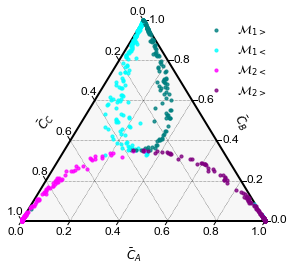

In [83]:
import ternary
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

plt.rcParams['font.family'] = 'Arial'

import ternary
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Arial'
import matplotlib.colors as mcolors
import pickle
# Import from refactored modular structure
from data_generation import GaussianMixtureModel, generate_icl_gmm_data
from datasets import ICLGMMDataset, collate_fn
from models import MatrixTreeMarkovICL
from training import train_model
from evaluation import test_icl
import torch
import random
from torch.utils.data import DataLoader

#path = "/Users/csfloyd/Dropbox/Projects/MarkovComputation/DirsICL/n_nodes_seed_3/2_5/"
#path = "/Users/csfloyd/Dropbox/Projects/MarkovComputation/DirsICL/n_nodes_seed_3_nobase2/3_4/"
path = "/Users/csfloyd/Dropbox/Projects/MarkovComputation/DirsICL/n_nodes_seed_3_nobase2/3_1/"

seed = 50
random.seed(seed)

# Load the results
results_path = path + "results.pkl"
with open(results_path, "rb") as file:
    data = pickle.load(file)

# Extract components
results = data['results']
history = data['history']
params = data['params']
execution_time = data['execution_time']

# Assuming you have the model parameters
model = MatrixTreeMarkovICL(
    n_nodes=params['n_nodes'], 
    z_dim=params['D'], 
    L=params['L'], 
    N=params['N']
)

# Load the saved weights
model_path = path + 'model.pt'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.load_state_dict(torch.load(model_path, map_location=device))

model.to(device)
model.eval()

gmm = GaussianMixtureModel(
    K=params['K'], 
    D=params['D'], 
    L=params['L'], 
    epsilon=params['epsilon'], 
    seed=params['seed'], 
    offset=params['offset']
)

train_data = generate_icl_gmm_data(gmm, params['train_samples'], params['N'], 
                                   novel_classes=False, exact_copy=params['exact_copy'], 
                                   B=params['B'], L=params['L'], shuffle_context=params['shuffle_context'], min_max_choice=params['min_max_choice'], unique_labels = params['unique_labels'])

train_loader = DataLoader(ICLGMMDataset(train_data), batch_size=params['batch_size'],
                          shuffle=True, collate_fn=collate_fn)





# Loop to collect n_samples points
n_samples = 1250
n_samples_2 = 750
p_steady_list = []
targets_list = []
class_list = []
min_max_list = []
model.eval()


with torch.no_grad():
    for i in list(range(n_samples)) + list(range(n_samples+50, n_samples+50+n_samples_2)):
        # Get a single example from the training dataset
        z_seq, labels, targets = train_loader.dataset[i]
        
        # Add batch dimension and move to device
        z_seq = z_seq.unsqueeze(0).to(device)  # Shape: (1, N+1, D)
        labels = labels.unsqueeze(0).to(device)  # Shape: (1, N)
        targets = targets.unsqueeze(0).to(device).long()  # Shape: (1,)
        # print(targets)
        # print(labels)
        # Find which element of labels equals the target
        matching_indices = (labels[0] == targets[0]).nonzero(as_tuple=True)[0]
        if len(matching_indices) > 0:
            class_idx = matching_indices[0].item()
        else:
            class_idx = -1  # No matching class found
        class_list.append(class_idx)
        
        # Flatten z_seq as the model expects
        z_flat = z_seq.reshape(1, -1)  # Shape: (1, (N+1)*D)
        
        # Compute the rate matrix K
        W_mat = model.compute_rate_matrix_W(z_flat)
        p_steady = model.direct_solve_steady_state(W_mat)  # default

        z_array = np.array(z_flat)[0]
        # if np.max(np.array(p_steady)) <= 0.6:
        #     print(z_array)

        if z_array[class_idx] > z_array[1-class_idx]:
            min_max_list.append(1)
        else:
            min_max_list.append(0)

        # Store results
        p_steady_list.append(p_steady.cpu())
        targets_list.append(targets.cpu())

# Convert lists to tensors for easier manipulation
p_steady_all = torch.cat(p_steady_list, dim=0)  # Shape: (n_samples, n_nodes)
targets_all = torch.cat(targets_list, dim=0)  # Shape: (n_samples,)


scale = 1
fs = 12
offset = 0.15

fig, ax = plt.subplots(figsize= 0.6 *  np.array([7, 6]))
#fig.set_size_inches(5, 5)
tax = ternary.TernaryAxesSubplot(scale=scale, ax=ax)
#tax.set_title("Steady State Distribution by Context Class", fontsize=fs)
tax.boundary(linewidth=2.0)
tax.gridlines(multiple=0.2, color="black")


ternary_points = (p_steady_all.numpy() * scale).tolist()

# Get unique classes for coloring
class_array = np.array(class_list)
unique_classes = np.unique(class_array)
colors = ['cyan', 'magenta', 'yellow', 'purple', 'orange', 'brown', 'pink', 'gray', 'cyan']

coloff = 0.5
def adjust_lightness(color, amount=0.5):
    """
    Lightens or darkens the given color.
    amount > 1.0 makes it lighter, amount < 1.0 makes it darker.
    """
    try:
        c = mcolors.cnames[color]
    except:
        c = color
    c = mcolors.to_rgb(c)
    # Convert to HSL (Hue, Saturation, Lightness)
    c = np.array(mcolors.rgb_to_hsv(c))
    # Adjust the lightness (V in HSV)
    c[2] = min(1.0, c[2] * amount)
    return mcolors.hsv_to_rgb(c)

# Plot points colored by class
labeled = set()
for idx, class_idx in enumerate(unique_classes):
    mask = (class_array == class_idx)
    # Get original indices where mask is True
    original_indices = np.where(mask)[0]
    
    for orig_idx in original_indices:
        point = ternary_points[orig_idx]
        marker_shape = 's' if min_max_list[orig_idx] == 0 else 'o'
        amt = 1-coloff if min_max_list[orig_idx] == 0 else 1+coloff   
        color = adjust_lightness(colors[idx], amt)
        # Only add label for first point of each class
        min_max_val = min_max_list[orig_idx]

        # Create unique key for this combination
        combo_key = (int(class_idx), min_max_val)
        
        # Only add label for first point of each (class, min_max) combination
        if combo_key not in labeled:
            suffix = ">" if min_max_val == 0 else "<"
            #label = f"ICL {int(class_idx + 1)}$_{{{suffix}}}$"
            #label = f"$M_{{{int(class_idx + 1)}{suffix}}}$"
            label = f"$\mathcal{{M}}_{{{int(class_idx + 1)}{suffix}}}$"
            labeled.add(combo_key)
        else:
            label = ""


        tax.scatter([point], marker='o', color=color, 
                    label=label, s=10, alpha=0.8, zorder=10)

tax.ticks(axis='lbr', multiple=0.2, linewidth=1, tick_formats="%.1f", offset=0.02, fontsize=fs)
# tax.bottom_axis_label(r"$\pi_A$", fontsize=fs+4, offset=offset)
# tax.right_axis_label(r"$\pi_B$", fontsize=fs+4, offset=offset)
# tax.left_axis_label(r"$\pi_C$", fontsize=fs+4, offset=offset)
tax.bottom_axis_label(r"$\bar{C}_A$", fontsize=fs, offset=offset)
tax.right_axis_label(r"$\bar{C}_B$", fontsize=fs, offset=offset)
tax.left_axis_label(r"$\bar{C}_C$", fontsize=fs, offset=offset)
tax.get_axes().axis('off')
ax = tax.get_axes()
handles, labels = ax.get_legend_handles_labels()
order = [0,1,3,2]
tax.legend([handles[i] for i in order], [labels[i] for i in order], 
           fontsize=fs, frameon=False, ncol=1, loc='upper right')

plt.tight_layout()
plt.show()

save_path = '/Users/csfloyd/Dropbox/Projects/MarkovComputation/Figures/'
fig.savefig(save_path + 'TernaryPlotBothBranches.png', dpi=300, bbox_inches='tight')

In [85]:
# ============================================================================
# IMPORTS
# ============================================================================
import plotly.graph_objects as go
import numpy as np

#path = "/Users/csfloyd/Dropbox/Projects/MarkovComputation/DirsICL/n_nodes_seed_3/2_5/"
path = "/Users/csfloyd/Dropbox/Projects/MarkovComputation/DirsICL/n_nodes_seed_3_nobase2/3_1/"

seed = 5
random.seed(seed)

# Load the results
results_path = path + "results.pkl"
with open(results_path, "rb") as file:
    data = pickle.load(file)

# Extract components
results = data['results']
history = data['history']
params = data['params']
execution_time = data['execution_time']

# Assuming you have the model parameters
model = MatrixTreeMarkovICL(
    n_nodes=params['n_nodes'], 
    z_dim=params['D'], 
    L=params['L'], 
    N=params['N']
)

# Load the saved weights
model_path = path + 'model.pt'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.load_state_dict(torch.load(model_path, map_location=device))

model.to(device)
model.eval()

gmm = GaussianMixtureModel(
    K=params['K'], 
    D=params['D'], 
    L=params['L'], 
    epsilon=params['epsilon'], 
    seed=params['seed'], 
    offset=params['offset']
)

train_data = generate_icl_gmm_data(gmm, params['train_samples'], params['N'], 
                                   novel_classes=False, exact_copy=params['exact_copy'], 
                                   B=params['B'], L=params['L'], shuffle_context=params['shuffle_context'], min_max_choice=params['min_max_choice'], unique_labels = params['unique_labels'])

train_loader = DataLoader(ICLGMMDataset(train_data), batch_size=params['batch_size'],
                          shuffle=True, collate_fn=collate_fn)

# ============================================================================
# CONFIGURATION
# ============================================================================

# Set number of states (2 or 3)
NUM_STATES = 3  # Change to 2 for 2-state case

# Index pairs for K_params access
INDEX_PAIRS = {
    'one': [0, 2],
    'two': [2, 1],
    'three': [0, 1],
    'four': [1, 2],
    'five': [1, 0],
    'six': [2, 0]
}

# Color scheme
VECTOR_COLORS = {
    'A': 'red',
    'B': 'blue',
    'C': 'green'
}

PLANE_COLORS = {
    'ICL1': 'darkturquoise',
    'ICL2': 'magenta'
}

# Visualization parameters
MAX_RANGE = 3
SHOW_LEGEND = False
COLOFF = 0.3  # Color offset for lightness adjustment
NUM_SAMPLES = 100
VEC_SCALE = 0.075 # 0.05, 0.15

# ============================================================================
# HELPER FUNCTIONS
# ============================================================================

def add_arrow(fig, start, end, color, name, width=5, sizeref=0.6, showlegend=False):
    """Add a 3D arrow to the figure with a cone at the tip."""
    # Arrow shaft
    fig.add_trace(go.Scatter3d(
        x=[start[0], end[0]],
        y=[start[1], end[1]],
        z=[start[2], end[2]],
        mode='lines',
        line=dict(color=color, width=width),
        name=name,
        showlegend=showlegend if name else False
    ))
    
    # Arrowhead cone
    fig.add_trace(go.Cone(
        x=[end[0]], y=[end[1]], z=[end[2]],
        u=[end[0] - start[0]],
        v=[end[1] - start[1]],
        w=[end[2] - start[2]],
        colorscale=[[0, color], [1, color]],
        showscale=False,
        sizemode='absolute',
        sizeref=sizeref,
        showlegend=False
    ))


def get_k_param(model, key):
    """Extract K_params for a given index pair."""
    idx = INDEX_PAIRS[key]
    return model.K_params[idx[0], idx[1], :].detach().numpy()


def add_plane(fig, v1, v2, color, name, max_range, showlegend=False):
    """Add a semi-transparent plane to the figure."""
    t1 = np.linspace(-max_range, max_range, 20)
    t2 = np.linspace(-max_range, max_range, 20)
    T1, T2 = np.meshgrid(t1, t2)
    
    X = T2 * v2[0] + T1 * v1[0]
    Y = T2 * v2[1] + T1 * v1[1]
    Z = T2 * v2[2] + T1 * v1[2]
    
    fig.add_trace(go.Surface(
        x=X, y=Y, z=Z,
        opacity=0.1,
        colorscale=[[0, color], [1, color]],
        showscale=False,
        name=name,
        showlegend=showlegend
    ))


# ============================================================================
# COMPUTE VECTORS AND PROBABILITIES
# ============================================================================

if NUM_STATES == 2:
    # 2-state case: simple K_params extraction
    one_inds = [0, 1]
    two_inds = [1, 0]
    A = model.K_params[one_inds[0], one_inds[1], :].detach().numpy()
    B = model.K_params[two_inds[0], two_inds[1], :].detach().numpy()
    
    vectors = {
        'A': A,
        'B': B
    }
    
elif NUM_STATES == 3:
    # 3-state case: combined vectors from K_params
    A1 = get_k_param(model, 'one') + get_k_param(model, 'two')
    A2 = get_k_param(model, 'three') + get_k_param(model, 'four')
    A3 = get_k_param(model, 'one') + get_k_param(model, 'three')
    
    B1 = get_k_param(model, 'five') + get_k_param(model, 'one')
    B2 = get_k_param(model, 'four') + get_k_param(model, 'six')
    B3 = get_k_param(model, 'four') + get_k_param(model, 'five')
    
    C1 = get_k_param(model, 'six') + get_k_param(model, 'three')
    C2 = get_k_param(model, 'five') + get_k_param(model, 'two')
    C3 = get_k_param(model, 'six') + get_k_param(model, 'two')
    
    vectors = {
        'A1': A1, 'A2': A2, 'A3': A3,
        'B1': B1, 'B2': B2, 'B3': B3,
        'C1': C1, 'C2': C2, 'C3': C3
    }

# Compute class probabilities
if NUM_STATES == 2:
    piA = np.exp(z_flat @ vectors['A'])
    piB = np.exp(z_flat @ vectors['B'])
    Z = piA + piB
    piAf = (piA / Z).item()
    piBf = (piB / Z).item()
    print(f"Class probabilities: [A: {piAf:.4f}, B: {piBf:.4f}]")
    
elif NUM_STATES == 3:
    piA = np.exp(z_flat @ vectors['A1']) + np.exp(z_flat @ vectors['A2']) + np.exp(z_flat @ vectors['A3'])
    piB = np.exp(z_flat @ vectors['B1']) + np.exp(z_flat @ vectors['B2']) + np.exp(z_flat @ vectors['B3'])
    piC = np.exp(z_flat @ vectors['C1']) + np.exp(z_flat @ vectors['C2']) + np.exp(z_flat @ vectors['C3'])
    Z = piA + piB + piC
    piAf = (piA / Z).item()
    piBf = (piB / Z).item()
    piCf = (piC / Z).item()
    print(f"Class probabilities: [A: {piAf:.4f}, B: {piBf:.4f}, C: {piCf:.4f}]")


# ============================================================================
# INITIALIZE 3D FIGURE
# ============================================================================

fig = go.Figure()
origin = np.array([0, 0, 0])


# ============================================================================
# ADD VECTOR ARROWS
# ============================================================================

for idx, (name, vec) in enumerate(vectors.items()):
    letter = name[0]
    color = VECTOR_COLORS[letter]
    
    if NUM_STATES == 2:
        # For 2-state: show legend and use names 'A' and 'B'
        display_name = name
        showlegend = SHOW_LEGEND
    else:
        # For 3-state: show legend only for first vector of each group (A, B, C)
        display_name = letter if idx % 3 == 0 else None
        showlegend = (idx % 3 == 0) and SHOW_LEGEND

    vec_scale = VEC_SCALE # 0.05, 0.15
    add_arrow(fig, origin, vec_scale * vec, color, display_name, 
              width=5, sizeref=0.4, showlegend=showlegend)


# ============================================================================
# ADD GEOMETRIC ELEMENTS (PLANES AND LINES)
# ============================================================================

# Add ICL planes
add_plane(fig, 
          v1=np.array([1, 0, 1]), 
          v2=np.array([0, 1, 0]), 
          color=PLANE_COLORS['ICL1'], 
          name='ICL 1', 
          max_range=MAX_RANGE,
          showlegend=SHOW_LEGEND)

add_plane(fig, 
          v1=np.array([0, 1, 1]), 
          v2=np.array([1, 0, 0]), 
          color=PLANE_COLORS['ICL2'], 
          name='ICL 2', 
          max_range=MAX_RANGE,
          showlegend=SHOW_LEGEND)

# Add line through origin and (1,1,1)
t_line = np.linspace(-MAX_RANGE, MAX_RANGE, 100)
line_direction = np.array([1, 1, 1])

fig.add_trace(go.Scatter3d(
    x=t_line * line_direction[0],
    y=t_line * line_direction[1],
    z=t_line * line_direction[2],
    mode='lines',
    line=dict(color='black', width=6),
    name='Line (1,1,1)',
    showlegend=SHOW_LEGEND
))


# ============================================================================
# ADD DATA POINTS FROM TRAIN LOADER
# ============================================================================

scatter_x, scatter_y, scatter_z = [], [], []
point_colors = []

for i in range(NUM_SAMPLES):
    # Get batch data
    z_seq, labels, targets = train_loader.dataset[i]
    z_seq = z_seq.unsqueeze(0).to(device)
    z_flat = z_seq.reshape(1, -1)
    
    # Extract first 3 coordinates
    scatter_x.append(z_flat[0, 0].item())
    scatter_y.append(z_flat[0, 1].item())
    scatter_z.append(z_flat[0, 2].item())
    
    # Determine color based on class matching
    matching_indices = (labels.unsqueeze(0).to(device)[0] == targets.unsqueeze(0).to(device).long()[0]).nonzero(as_tuple=True)[0]
    if len(matching_indices) > 0:
        class_idx = matching_indices[0].item()
    else:
        class_idx = -1  # No matching class found
    z_array = np.array(z_flat)[0]
    class_dominant = 0 if z_array[class_idx] > z_array[1-class_idx] else 1
    lightness_amt = 1 - COLOFF if class_dominant == 1 else 1 + COLOFF
    
    if targets.item() == labels[0].item():
        color = adjust_lightness(PLANE_COLORS['ICL1'], lightness_amt)
    elif targets.item() == labels[1].item():
        color = adjust_lightness(PLANE_COLORS['ICL2'], lightness_amt)
    
    point_colors.append(color)
    
    # Add line from origin to data point
    vec = z_flat[0, 0:3].detach().numpy()
    t = np.linspace(0, 1, 100)
    
    fig.add_trace(go.Scatter3d(
        x=t * vec[0],
        y=t * vec[1],
        z=t * vec[2],
        mode='lines',
        opacity = 1,
        line=dict(color=[color for _ in range(len(t))], width=1),
        showlegend=False
    ))

# Add scatter plot of data points
fig.add_trace(go.Scatter3d(
    x=scatter_x, y=scatter_y, z=scatter_z,
    mode='markers',
    marker=dict(size=4, color=point_colors, opacity=1),
    name='Data pts'
))


# ============================================================================
# CONFIGURE LAYOUT AND DISPLAY
# ============================================================================

fig.update_layout(
    scene=dict(
        xaxis_title="z<sub>1</sub>",
        yaxis_title="z<sub>2</sub>",
        zaxis_title="z<sub>q</sub>",
        xaxis=dict(range=[-MAX_RANGE, MAX_RANGE], showgrid=True, showbackground=False, gridcolor="whitesmoke", tickfont = dict(size = 18), title_font = dict(size = 30)),#, title_font=dict(family="Arial, sans-serif", size=24, color='black')),
        yaxis=dict(range=[-MAX_RANGE, MAX_RANGE], showgrid=True, showbackground=False, gridcolor="whitesmoke", tickfont = dict(size = 18), title_font = dict(size = 30)),#, title_font=dict(family="Arial, sans-serif", size=24, color='black')),
        zaxis=dict(range=[-MAX_RANGE, MAX_RANGE], showgrid=True, showbackground=False, gridcolor="whitesmoke", tickfont = dict(size = 18), title_font = dict(size = 30)),#, title_font=dict(family="Arial, sans-serif", size=24, color='black')),
        aspectmode='cube',
        camera=dict(eye=dict(x=-1.2, y=-1.2, z=-1)),
        bgcolor='white'
    ),
    width=1000,
    height=800,
    showlegend=SHOW_LEGEND,
    margin=dict(l=0, r=0, t=0, b=0), 
    font=dict(family="Arial, sans-serif", size=24, color='black')
)

fig.show()
save_path = '/Users/csfloyd/Dropbox/Projects/MarkovComputation/Figures/'
fig.write_image(save_path + '3DPlotThreeNodesBothBranches.png', scale=2)


  Initialized ICL Attention model (L=128 classes, attention over 2 context items)
  Label modulation: False
  Base rates learnable: True
  Base mask value: 0.0
  Sparsity K: rho_edge=1.000, rho_all=1.000
  Sparsity base_W: rho_edge=1.000
  K_params sparsity: 0.000 (27/27 active)
  base_W sparsity: 0.000 (9/9 active)
  Parameters: 42
Class probabilities: [A: 0.6197, B: 0.2671, C: 0.1132]


# Learning parameter scans

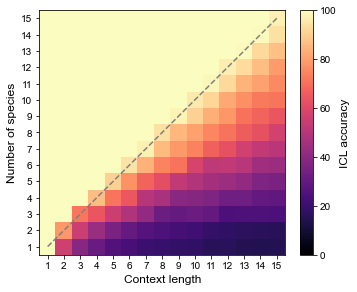

In [ ]:
# Import necessary components
import torch

# Import from refactored modular structure
from data_generation import GaussianMixtureModel, generate_icl_gmm_data
from datasets import ICLGMMDataset, collate_fn
from models import MatrixTreeMarkovICL
from training import train_model
from evaluation import test_icl

from torch.utils.data import DataLoader
import os
import time

import pickle
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Arial'
import numpy as np

param1_values = np.arange(1,16,1)
param2_values = np.arange(1,16,1)
param3_values = [1,2,3,4,5]
# param1_values = np.arange(4,6,1)
# param2_values = np.arange(5,16,1)
#len(np.arange(5,16,1)) * len(np.arange(4,6,1))
path_base = "/Users/csfloyd/Dropbox/Projects/MarkovComputation/DirsICL/n_nodes_N_seed/"


results_grid = np.zeros((len(param1_values), len(param2_values), len(param3_values)))
for i, param1 in enumerate(param1_values):
    for j, param2 in enumerate(param2_values):
        for k, param3 in enumerate(param3_values):
            path = path_base + str(param1) + "_" + str(param2) + "_" + str(param3) + "/"
            results_path = path + "results.pkl"
            try:
                with open(results_path, "rb") as file:
                    data = pickle.load(file)
                results = data['results']
                history = data['history']
                icl_acc = [val for val in history['icl_acc'] if val is not None]
                #results_grid[i, j] = icl_acc[-1]
                results_grid[i, j, k] = np.max(icl_acc)
            except:
                pass



# plot
fig, ax = plt.subplots(figsize=(5.5, 4.5))
fs = 12

results_grid_avg = np.mean(results_grid, axis = 2)
im = ax.imshow(results_grid_avg, cmap='magma', aspect='auto', origin='lower', vmin = 0, vmax = 100)
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("ICL accuracy", size = fs)
ax.set_xlabel('Context length', fontsize=fs)
ax.set_ylabel('Number of species', fontsize=fs)
# ax.set_xlabel('D')
# ax.set_ylabel('K')
ax.set_yticks(range(len(param2_values)), param2_values)
ax.set_xticks(range(len(param1_values)), param1_values)
#ax.set_title('ICL accuracy', fontsize=fs)

# Add diagonal line from bottom-left to top-right
ax.plot([0, len(param1_values)-1], [0, len(param2_values)-1], 
        color='gray', linestyle='--', linewidth=1.5)

# # Add text annotations for each cell
# for i in range(len(param1_values)):
#     for j in range(len(param2_values)):
#         text = ax.text(i, j, f'{results_grid[j, i]:.1f}',
#                        ha="center", va="center", color="gray", fontsize=10)

# plot
fig, ax = plt.subplots(figsize=(4.5, 1))
fs = 12
diag = np.array([np.mean(results_grid[i,i,:]) for i in range(len(param1_values))])
diag_std = np.array([np.std(results_grid[i,i,:]) for i in range(len(param1_values))])



# Add diagonal line with error bars
x_positions = range(len(param1_values))
ax.errorbar(x_positions, diag, yerr=diag_std, 
            color='black', linestyle='-', linewidth=1.5, 
            marker='o', markersize=4, capsize=3)
ax.set_ylim(50, 105)
ax.set_xlabel('Number of species', fontsize=fs)
ax.set_ylabel('ICL accuracy', fontsize=fs)
ax.set_xticks([i for i in range(len(param1_values)) if (param1_values[i] % 5 == 0) or (param1_values[i] == 1)])
ax.set_xticklabels([param1_values[i] for i in range(len(param1_values)) if (param1_values[i] % 5 == 0) or (param1_values[i] == 1)])

# plt.show()

# save_path = '/Users/csfloyd/Dropbox/Projects/MarkovComputation/Figures/'
# fig.savefig(save_path + 'ICLAccuracyDiag.png', dpi=300, bbox_inches='tight')

plt.show()

save_path = '/Users/csfloyd/Dropbox/Projects/MarkovComputation/Figures/'
fig.savefig(save_path + 'ICLAccuracy.png', dpi=300, bbox_inches='tight')

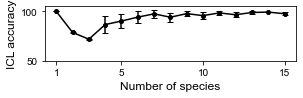

In [41]:
# plot
fig, ax = plt.subplots(figsize=(4.5, 1))
fs = 12
diag = np.array([np.mean(results_grid[i,i,:]) for i in range(len(param1_values))])
diag_std = np.array([np.std(results_grid[i,i,:]) for i in range(len(param1_values))])



# Add diagonal line with error bars
x_positions = range(len(param1_values))
ax.errorbar(x_positions, diag, yerr=diag_std, 
            color='black', linestyle='-', linewidth=1.5, 
            marker='o', markersize=4, capsize=3)
ax.set_ylim(50, 105)
ax.set_xlabel('Number of species', fontsize=fs)
ax.set_ylabel('ICL accuracy', fontsize=fs)
ax.set_xticks([i for i in range(len(param1_values)) if (param1_values[i] % 5 == 0) or (param1_values[i] == 1)])
ax.set_xticklabels([param1_values[i] for i in range(len(param1_values)) if (param1_values[i] % 5 == 0) or (param1_values[i] == 1)])

plt.show()

save_path = '/Users/csfloyd/Dropbox/Projects/MarkovComputation/Figures/'
fig.savefig(save_path + 'ICLAccuracyDiag.png', dpi=300, bbox_inches='tight')

<ipython-input-62-6d45d8f7396e>:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


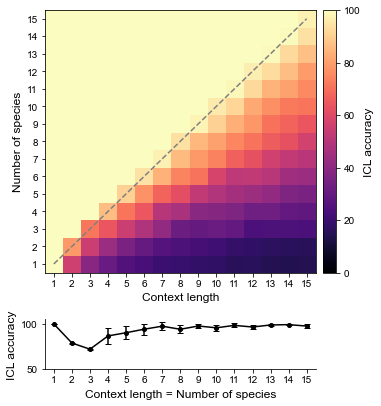

In [62]:
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Create figure with GridSpec
fig = plt.figure(figsize=1.1*np.array([4.75, 6]))
gs = gridspec.GridSpec(2, 2, width_ratios=[1, 0.05], height_ratios=[4, 0.75], 
                       hspace=0.3, wspace=0.05)
fs = 12

# === Top panel: Heatmap ===
ax_top = fig.add_subplot(gs[0, 0])
results_grid_avg = np.mean(results_grid, axis=2)
im = ax_top.imshow(results_grid_avg, cmap='magma', aspect='auto', origin='lower', vmin=0, vmax=100)

ax_top.set_ylabel('Number of species', fontsize=fs)
ax_top.set_yticks(range(len(param2_values)), param2_values)
# ax_top.set_xticks(range(len(param1_values)))
# ax_top.set_xticklabels([])  # Hide x labels on top panel

# Top panel x-axis
ax_top.set_xticks(range(len(param1_values)))
ax_top.set_xticklabels(param1_values)
ax_top.set_xlabel('Context length', fontsize=fs)

ax_top.set_xlim(-0.5, len(param1_values) - 0.5)
ax_bot.set_xlim(-0.5, len(param1_values) - 0.5)

# Add diagonal line from bottom-left to top-right
ax_top.plot([0, len(param1_values)-1], [0, len(param2_values)-1], 
            color='gray', linestyle='--', linewidth=1.5)

# Colorbar in its own column
cax = fig.add_subplot(gs[0, 1])
cbar = plt.colorbar(im, cax=cax)
cbar.set_label("ICL accuracy", size=fs)

# === Bottom panel: Diagonal slice ===
#ax_bot = fig.add_subplot(gs[1, 0], sharex=ax_top)
ax_bot = fig.add_subplot(gs[1, 0])  # removed sharex=ax_top
diag = np.array([np.mean(results_grid[i, i, :]) for i in range(len(param1_values))])
diag_std = np.array([np.std(results_grid[i, i, :]) for i in range(len(param1_values))])

x_positions = range(len(param1_values))
ax_bot.errorbar(x_positions, diag, yerr=diag_std, 
                color='black', linestyle='-', linewidth=1.5, 
                marker='o', markersize=4, capsize=3)
ax_bot.set_ylim(50, 105)
ax_bot.set_ylabel('ICL accuracy', fontsize=fs)
ax_bot.spines['top'].set_visible(False)
ax_bot.spines['right'].set_visible(False)

# Set x-axis properties
ax_bot.set_xlim(-0.5, len(param1_values) - 0.5)
ax_bot.set_xticks(range(len(param1_values)))
ax_bot.set_xticklabels(param1_values)
ax_bot.set_xlabel('Context length = Number of species', fontsize=fs)

plt.tight_layout()
plt.show()

save_path = '/Users/csfloyd/Dropbox/Projects/MarkovComputation/Figures/'
fig.savefig(save_path + 'ICLAccuracyStacked.png', dpi=300, bbox_inches='tight')

<ipython-input-132-55a9773d9104>:82: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(0, 1000)


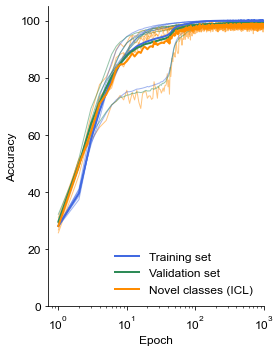

In [132]:
# Import necessary components
import torch

# Import from refactored modular structure
from data_generation import GaussianMixtureModel, generate_icl_gmm_data
from datasets import ICLGMMDataset, collate_fn
from models import MatrixTreeMarkovICL
from training import train_model
from evaluation import test_icl

from torch.utils.data import DataLoader
import os
import time

import pickle
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Arial'
import numpy as np


seed_vals = [1,2,3,4,5]
# Plot training history
fig, ax = plt.subplots(1, 1, figsize=(4, 5))
fs = 12

# Plot 1: Loss curves

epochs = range(1, 1001)

sub_alpha = 0.5

icl_color = 'darkorange'
train_color = 'royalblue'
val_color = 'seagreen'
icl_avs = np.zeros(len(epochs))
train_avs = np.zeros(len(epochs))
val_avs = np.zeros(len(epochs))
for seed in seed_vals:
    path = f"/Users/csfloyd/Dropbox/Projects/MarkovComputation/DirsICL/D_Nsamp_seed/8_25000_{seed}/"
    # Load the results
    results_path = path + "results.pkl"
    with open(results_path, "rb") as file:
        data = pickle.load(file)

    # Extract components
    results = data['results']
    history = data['history']
    params = data['params']
    execution_time = data['execution_time']


    icl_acc = np.array(history['icl_acc'])
    train_acc = np.array(history['train_acc'])
    val_acc = np.array(history['val_acc'])

    ax.plot(epochs, icl_acc, linewidth=1, color = icl_color, alpha = sub_alpha)
    ax.plot(epochs, train_acc, linewidth=1, color = train_color, alpha = sub_alpha)
    ax.plot(epochs, val_acc, linewidth=1, color = val_color, alpha = sub_alpha)

    icl_avs += icl_acc
    train_avs += train_acc
    val_avs += val_acc
icl_avs /= len(seed_vals)
train_avs /= len(seed_vals)
val_avs /= len(seed_vals)


ax.plot(epochs, train_avs, linewidth=2, color = train_color, label = 'Training set')
ax.plot(epochs, val_avs, linewidth=2, color = val_color, label = 'Validation set')
ax.plot(epochs, icl_avs, linewidth=2, color = icl_color, label = 'Novel classes (ICL)')

#ax.axhline(y=100, color='black', linestyle='--', linewidth=2, alpha=0.5, zorder = -10)

ax.set_xlabel('Epoch', fontsize=fs)
ax.set_ylabel('Accuracy', fontsize=fs)
ax.tick_params(axis='x', labelsize=fs)
ax.tick_params(axis='y', labelsize=fs)
ax.set_xscale('log')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim(0, 105)
ax.set_xlim(0, 1000)
#ax.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
ax.grid(False)#, alpha=0.3)
ax.legend(fontsize=fs, frameon=False, loc='lower right', ncol=1)

plt.tight_layout()
plt.show()
# Save the figure in high resolution
save_path = '/Users/csfloyd/Dropbox/Projects/MarkovComputation/Figures/'
fig.savefig(save_path + 'TrainingCurves.png', dpi=300, bbox_inches='tight')




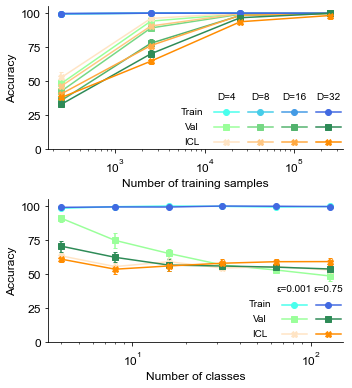

In [5]:
# Import necessary components
import torch

# Import from refactored modular structure
from data_generation import GaussianMixtureModel, generate_icl_gmm_data
from datasets import ICLGMMDataset, collate_fn
from models import MatrixTreeMarkovICL
from training import train_model
from evaluation import test_icl

from torch.utils.data import DataLoader
import os
import time

import pickle
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Arial'
import numpy as np

import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
from matplotlib.legend_handler import HandlerLine2D


# === Helper functions ===

def interpolate_color(color1, color2, t):
    """Interpolate between two colors. t=0 gives color1, t=1 gives color2."""
    c1 = np.array(mcolors.to_rgb(color1))
    c2 = np.array(mcolors.to_rgb(color2))
    return c1 + t * (c2 - c1)

def adjust_lightness(color, amount=0.5):
    """
    Lightens or darkens the given color.
    amount > 1.0 makes it lighter, amount < 1.0 makes it darker.
    """
    try:
        c = mcolors.cnames[color]
    except:
        c = color
    c = mcolors.to_rgb(c)
    c = np.array(mcolors.rgb_to_hsv(c))
    c[2] = min(1.0, c[2] * amount)
    return mcolors.hsv_to_rgb(c)

def create_table_legend(ax, row_labels, col_labels, colors_matrix, markers,
                        loc='lower right', fontsize=10, markersize=6, linewidth=1.5):
    """
    Create a table-style legend.
    """
    from matplotlib.lines import Line2D
    from matplotlib.patches import Patch
    from matplotlib.legend_handler import HandlerBase
    from matplotlib.text import Text
    
    # Custom handler that draws text as the "handle"
    class TextHandler(HandlerBase):
        def __init__(self, text, fontsize):
            self.text = text
            self.fontsize = fontsize
            super().__init__()
        
        def create_artists(self, legend, orig_handle, xdescent, ydescent, 
                           width, height, fontsize, trans):
            txt = Text(width/2, height/2, self.text, 
                       fontsize=self.fontsize,
                       ha='center', va='center',
                       transform=trans)
            return [txt]
    
    n_rows = len(row_labels)
    n_cols = len(col_labels)
    
    handles = []
    labels = []
    handler_map = {}
    
    def spacer_handle():
        h = Patch(facecolor='none', edgecolor='none')
        return h
    
    # Build in COLUMN order
    
    # Column 0: empty corner + row labels
    h = spacer_handle()
    handles.append(h)
    labels.append('')
    
    for i in range(n_rows):
        h = spacer_handle()
        handles.append(h)
        handler_map[h] = TextHandler(row_labels[i], fontsize)
        labels.append('')
    
    # Columns 1+: column header (as text handle) + markers
    for j in range(n_cols):
        # Column header as text handle
        h = spacer_handle()
        handles.append(h)
        handler_map[h] = TextHandler(col_labels[j], fontsize)
        labels.append('')
        
        # Markers for each row
        for i in range(n_rows):
            handles.append(Line2D([0], [0],
                                  marker=markers[i],
                                  color=colors_matrix[i][j],
                                  linestyle='-',
                                  markersize=markersize,
                                  linewidth=linewidth))
            labels.append('')
    
    legend = ax.legend(
        handles, labels,
        loc=loc,
        ncol=n_cols + 1,
        fontsize=fontsize,
        frameon=False,
        handlelength=2.5,
        handleheight=1.0,
        handletextpad=0.1,
        columnspacing=0.8,
        labelspacing=0.5,
        borderaxespad=-0.25,     # padding between legend and axes
        handler_map=handler_map,
    )
    
    return legend


# === Parameters ===

D_vals = [4, 8, 16, 32]
Nsamp_vals = [250, 2500, 25000, 250000]
L_vals = [4, 8, 16, 32, 64, 128]
epsilon_vals = [0.001, 0.75]
seed_vals = [1, 2, 3, 4, 5]

# Plot settings
fig, axes = plt.subplots(2, 1, figsize=(5, 5.5))
fs = 12
markersize = 6
capsize = 2
col_off_up = 0.0
col_off_down = 0.4
pos = 'lower right'

icl_color = 'darkorange'
train_color = 'royalblue'
val_color = 'seagreen'


# === Load D vs Nsamp data ===

D_Nsamp_train = np.zeros((len(D_vals), len(Nsamp_vals), len(seed_vals)))
D_Nsamp_val = np.zeros((len(D_vals), len(Nsamp_vals), len(seed_vals)))
D_Nsamp_icl = np.zeros((len(D_vals), len(Nsamp_vals), len(seed_vals)))

for i, D in enumerate(D_vals):
    for j, Nsamp in enumerate(Nsamp_vals):
        for k, seed in enumerate(seed_vals):
            try:
                path = f"/Users/csfloyd/Dropbox/Projects/MarkovComputation/DirsICL/D_Nsamp_seed/{D}_{Nsamp}_{seed}/"
                results_path = path + "results.pkl"
                with open(results_path, "rb") as file:
                    data = pickle.load(file)
            except:
                print(f"No results found for D={D}, Nsamp={Nsamp}, seed={seed}")
                continue

            history = data['history']
            D_Nsamp_train[i, j, k] = np.max(history['train_acc'])
            D_Nsamp_val[i, j, k] = np.max(history['val_acc'])
            D_Nsamp_icl[i, j, k] = np.max(history['icl_acc'])

D_Nsamp_train_avs = np.mean(D_Nsamp_train, axis=2)
D_Nsamp_val_avs = np.mean(D_Nsamp_val, axis=2)
D_Nsamp_icl_avs = np.mean(D_Nsamp_icl, axis=2)
D_Nsamp_train_std = np.std(D_Nsamp_train, axis=2)
D_Nsamp_val_std = np.std(D_Nsamp_val, axis=2)
D_Nsamp_icl_std = np.std(D_Nsamp_icl, axis=2)


# === Color maps for D panel ===

n_D = len(D_vals)
icl_color_map_D = [interpolate_color(adjust_lightness('bisque', 1+col_off_down), 
                                      adjust_lightness(icl_color, 1-col_off_up), 
                                      i / max(n_D - 1, 1)) for i in range(n_D)]
train_color_map_D = [interpolate_color(adjust_lightness('turquoise', 1+col_off_down), 
                                        adjust_lightness(train_color, 1-col_off_up), 
                                        i / max(n_D - 1, 1)) for i in range(n_D)]
val_color_map_D = [interpolate_color(adjust_lightness('lightgreen', 1+col_off_down), 
                                      adjust_lightness(val_color, 1-col_off_up), 
                                      i / max(n_D - 1, 1)) for i in range(n_D)]


# === Top panel: D vs Nsamp ===

ax = axes[0]
for i, D in enumerate(D_vals):
    ax.errorbar(Nsamp_vals, D_Nsamp_train_avs[i, :], yerr=D_Nsamp_train_std[i, :], 
                color=train_color_map_D[i], markersize=markersize, fmt='o-', capsize=capsize)
    ax.errorbar(Nsamp_vals, D_Nsamp_val_avs[i, :], yerr=D_Nsamp_val_std[i, :], 
                color=val_color_map_D[i], markersize=markersize, fmt='s-', capsize=capsize)
    ax.errorbar(Nsamp_vals, D_Nsamp_icl_avs[i, :], yerr=D_Nsamp_icl_std[i, :], 
                color=icl_color_map_D[i], markersize=markersize, fmt='X-', capsize=capsize)

ax.set_xlabel('Number of training samples', fontsize=fs)
ax.set_ylabel('Accuracy', fontsize=fs)
ax.tick_params(axis='x', labelsize=fs)
ax.tick_params(axis='y', labelsize=fs)
ax.set_xscale('log')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(False)
ax.set_ylim(0, 105)

# Create table legend for top panel
create_table_legend(
    ax,
    row_labels=['Train', 'Val', 'ICL'],
    col_labels=[f'D={D}' for D in D_vals],
    colors_matrix=[train_color_map_D, val_color_map_D, icl_color_map_D],
    markers=['o', 's', 'X'],
    loc=pos,
    fontsize=fs-2
)



# === Load L vs epsilon data ===

L_epsilon_train = np.zeros((len(L_vals), len(epsilon_vals), len(seed_vals)))
L_epsilon_val = np.zeros((len(L_vals), len(epsilon_vals), len(seed_vals)))
L_epsilon_icl = np.zeros((len(L_vals), len(epsilon_vals), len(seed_vals)))

for i, L in enumerate(L_vals):
    for j, epsilon in enumerate(epsilon_vals):
        for k, seed in enumerate(seed_vals):
            try:
                path = f"/Users/csfloyd/Dropbox/Projects/MarkovComputation/DirsICL/L_epsilon_seed/{L}_{epsilon}_{seed}/"
                results_path = path + "results.pkl"
                with open(results_path, "rb") as file:
                    data = pickle.load(file)
            except:
                print(f"No results found for L={L}, epsilon={epsilon}, seed={seed}")
                continue

            history = data['history']
            L_epsilon_train[i, j, k] = np.max(history['train_acc'])
            L_epsilon_val[i, j, k] = np.max(history['val_acc'])
            L_epsilon_icl[i, j, k] = np.max(history['icl_acc'])

L_epsilon_train_avs = np.mean(L_epsilon_train, axis=2)
L_epsilon_val_avs = np.mean(L_epsilon_val, axis=2)
L_epsilon_icl_avs = np.mean(L_epsilon_icl, axis=2)
L_epsilon_train_std = np.std(L_epsilon_train, axis=2)
L_epsilon_val_std = np.std(L_epsilon_val, axis=2)
L_epsilon_icl_std = np.std(L_epsilon_icl, axis=2)


# === Color maps for epsilon panel ===

n_eps = len(epsilon_vals)
icl_color_map_eps = [interpolate_color(adjust_lightness('bisque', 1+col_off_down), 
                                        adjust_lightness(icl_color, 1-col_off_up), 
                                        i / max(n_eps - 1, 1)) for i in range(n_eps)]
train_color_map_eps = [interpolate_color(adjust_lightness('turquoise', 1+col_off_down), 
                                          adjust_lightness(train_color, 1-col_off_up), 
                                          i / max(n_eps - 1, 1)) for i in range(n_eps)]
val_color_map_eps = [interpolate_color(adjust_lightness('lightgreen', 1+col_off_down), 
                                        adjust_lightness(val_color, 1-col_off_up), 
                                        i / max(n_eps - 1, 1)) for i in range(n_eps)]


# === Bottom panel: L vs epsilon ===

ax = axes[1]
for j, epsilon in enumerate(epsilon_vals):
    ax.errorbar(L_vals, L_epsilon_train_avs[:, j], yerr=L_epsilon_train_std[:, j], 
                color=train_color_map_eps[j], markersize=markersize, fmt='o-', capsize=capsize)
    ax.errorbar(L_vals, L_epsilon_val_avs[:, j], yerr=L_epsilon_val_std[:, j], 
                color=val_color_map_eps[j], markersize=markersize, fmt='s-', capsize=capsize)
    ax.errorbar(L_vals, L_epsilon_icl_avs[:, j], yerr=L_epsilon_icl_std[:, j], 
                color=icl_color_map_eps[j], markersize=markersize, fmt='X-', capsize=capsize)

ax.set_xlabel('Number of classes', fontsize=fs)
ax.set_ylabel('Accuracy', fontsize=fs)
ax.tick_params(axis='x', labelsize=fs)
ax.tick_params(axis='y', labelsize=fs)
ax.set_xscale('log')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(False)
ax.set_ylim(0, 105)

# Create table legend for bottom panel
create_table_legend(
    ax,
    row_labels=['Train', 'Val', 'ICL'],
    col_labels=[f'ε={eps}' for eps in epsilon_vals],
    colors_matrix=[train_color_map_eps, val_color_map_eps, icl_color_map_eps],
    markers=['o', 's', 'X'],
    loc=pos,
    fontsize=fs-2
)


plt.tight_layout()
plt.show()

# Save the figure in high resolution
save_path = '/Users/csfloyd/Dropbox/Projects/MarkovComputation/Figures/'
#fig.savefig(save_path + 'TrainingScans.png', dpi=300, bbox_inches='tight')

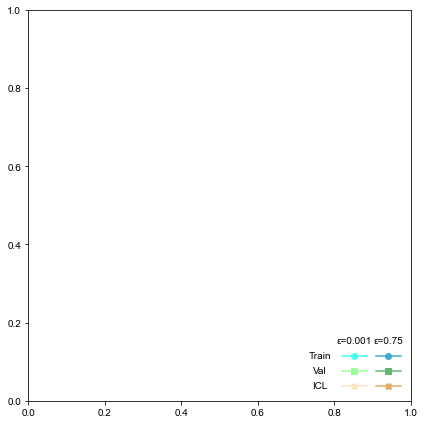

In [ ]:
# def create_table_legend(ax, row_labels, col_labels, colors_matrix, markers,
#                         loc='lower right', fontsize=10, markersize=6, linewidth=1.5):
#     """
#     Create a table-style legend.
    
#     rows = Train, Val, ICL (row_labels)
#     cols = D=4, D=8, ... (col_labels)
#     colors_matrix[i][j] = color for row i, column j
#     markers[i] = marker for row i
#     """
#     from matplotlib.lines import Line2D
    
#     n_rows = len(row_labels)
#     n_cols = len(col_labels)
    
#     handles = []
#     labels = []
    
#     def spacer_handle():
#         return Line2D([0], [0], color='white', marker='None', linestyle='-', linewidth=0)
    
#     # Build in COLUMN order (matplotlib fills columns first with ncol)
    
#     # Column 0: empty corner + row labels
#     handles.append(spacer_handle())
#     labels.append('')  # empty corner
#     for i in range(n_rows):
#         handles.append(spacer_handle())
#         labels.append(row_labels[i])
    
#     # Columns 1+: column header + markers for that column
#     for j in range(n_cols):
#         # Column header
#         handles.append(spacer_handle())
#         labels.append(col_labels[j])
        
#         # Markers for each row in this column
#         for i in range(n_rows):
#             handles.append(Line2D([0], [0],
#                                   marker=markers[i],
#                                   color=colors_matrix[i][j],
#                                   linestyle='-',
#                                   markersize=markersize,
#                                   linewidth=linewidth))
#             labels.append('')
#     print(labels)
#     print(handles)
#     legend = ax.legend(
#         handles, labels,
#         loc=loc,
#         ncol=n_cols +1,
#         fontsize=fontsize,
#         frameon=False,
#         handlelength=2.0,
#         handleheight=0.7,
#         handletextpad=0.3,
#         columnspacing=0.8,
#         labelspacing=0.5,
#     )
    
#     return legend



# Create empty figure
fig, ax = plt.subplots(figsize=(6,6))

create_table_legend(
    ax,
    row_labels=['Train', 'Val', 'ICL'],
    col_labels=[f'ε={eps}' for eps in epsilon_vals],
    colors_matrix=[train_color_map_eps, val_color_map_eps, icl_color_map_eps],
    markers=['o', 's', 'X'],
    loc='lower right',
    fontsize=fs-2
)

plt.tight_layout()
plt.show()

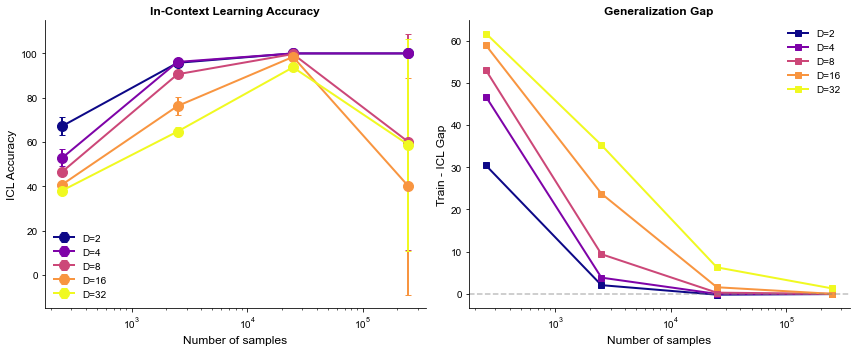

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
cmap = plt.cm.plasma
D_colors = [cmap(i / (len(D_vals) - 1)) for i in range(len(D_vals))]

# Left: ICL accuracy (main result)
ax = axes[0]
for i, D in enumerate(D_vals):
    ax.errorbar(Nsamp_vals, D_Nsamp_icl_avs[i, :], yerr=D_Nsamp_icl_std[i, :], 
                color=D_colors[i], markersize=10, fmt='o-', capsize=3, 
                linewidth=2, label=f'D={D}')
ax.set_xlabel('Number of samples', fontsize=fs)
ax.set_ylabel('ICL Accuracy', fontsize=fs)
ax.set_xscale('log')
ax.legend(frameon=False)
ax.set_title('In-Context Learning Accuracy', fontweight='bold')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Right: Gap between train and ICL (generalization)
ax = axes[1]
for i, D in enumerate(D_vals):
    gap = D_Nsamp_train_avs[i, :] - D_Nsamp_icl_avs[i, :]
    ax.plot(Nsamp_vals, gap, color=D_colors[i], marker='s', 
            linewidth=2, label=f'D={D}')
ax.set_xlabel('Number of samples', fontsize=fs)
ax.set_ylabel('Train - ICL Gap', fontsize=fs)
ax.set_xscale('log')
ax.axhline(0, color='gray', linestyle='--', alpha=0.5)
ax.legend(frameon=False)
ax.set_title('Generalization Gap', fontweight='bold')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()

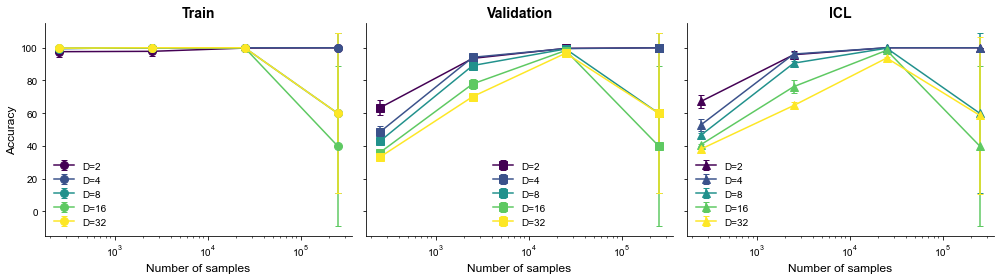

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4), sharey=True)
fs = 12

# Use a proper colormap for D values
cmap = plt.cm.viridis
D_colors = [cmap(i / (len(D_vals) - 1)) for i in range(len(D_vals))]

metrics = [
    ('Train', D_Nsamp_train_avs, D_Nsamp_train_std, 'o-'),
    ('Validation', D_Nsamp_val_avs, D_Nsamp_val_std, 's-'),
    ('ICL', D_Nsamp_icl_avs, D_Nsamp_icl_std, '^-')
]

for ax, (metric_name, avs, std, marker) in zip(axes, metrics):
    for i, D in enumerate(D_vals):
        ax.errorbar(Nsamp_vals, avs[i, :], yerr=std[i, :], 
                    color=D_colors[i], markersize=8, fmt=marker, 
                    capsize=3, label=f'D={D}')
    
    ax.set_xlabel('Number of samples', fontsize=fs)
    ax.set_xscale('log')
    ax.set_title(metric_name, fontsize=fs+2, fontweight='bold')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend(fontsize=fs-2, frameon=False)

axes[0].set_ylabel('Accuracy', fontsize=fs)
plt.tight_layout()

In [171]:
np.exp(np.log(1e6))

999999.9999999995

# Sparsity plot

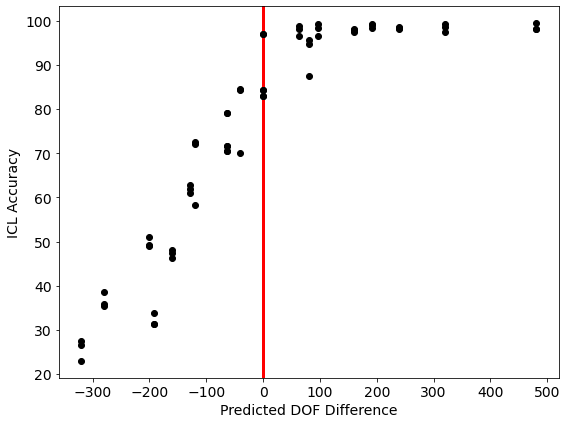

In [10]:
# Import necessary components
import torch
import numpy as np

# Import from refactored modular structure
from data_generation import GaussianMixtureModel, generate_icl_gmm_data
from datasets import ICLGMMDataset, collate_fn
from models import MatrixTreeMarkovICL, NonlinearMarkovICL
from training import train_model
from evaluation import test_icl

from models.nonlinear_markov_icl import *
from models.markov_icl import *
from torch.utils.data import DataLoader
import os
import time
import pickle
import matplotlib.pyplot as plt
import numpy as np

seeds = [1,2,3]
nodes = [4,5]
sparsities = np.arange(0.1, 1.1, 0.1)

needed_dof_list = []
available_dof_list = []
icl_accuracy_list = []
iwl_accuracy_list = []

for seed in seeds:
    for node in nodes:
        for sparsity in sparsities:
            sparsity = round(sparsity, 1)
            path = f"/Users/csfloyd/Dropbox/Projects/MarkovComputation/DirsICL/rho_edge_seed_n_nodes{node}_2/{sparsity}_{seed}/"
            results_path = path + "results.pkl"
            with open(results_path, "rb") as file:
                data = pickle.load(file)

            # Extract components
            results = data['results']
            history = data['history']
            params = data['params']
            execution_time = data['execution_time']

            needed_dof = 2 * params['D'] * params['N'] * (params['N']+1)
            #available_dof = params['sparsity_rho_all'] * params['sparsity_rho_edge'] * (params['N']+1) * params['D'] * params['n_nodes'] * (params['n_nodes']-1)
            model = load_model(params, path, print_creation=False)
            available_dof = model.get_non_zero_count_K()

            needed_dof_list.append(needed_dof)
            available_dof_list.append(available_dof)

            icl_acc = [val for val in history['icl_acc'] if val is not None][-1]
            iwl_acc = [val for val in history['iwl_acc'] if val is not None][-1]

            icl_accuracy_list.append(icl_acc)
            iwl_accuracy_list.append(iwl_acc)


dof_diff_list = np.array(available_dof_list) - np.array(needed_dof_list)

plt.figure(figsize=(8, 6))
fs = 14
plt.scatter(dof_diff_list, icl_accuracy_list, label='ICL Accuracy', marker='o', color='black')
#plt.scatter(dof_diff_list, iwl_accuracy_list, label='IWL Accuracy', marker='x')
plt.axvline(x=0, color='red', linestyle='-', linewidth=3, zorder=-10)
plt.xlabel('Predicted DOF Difference',fontsize=fs)
plt.ylabel('ICL Accuracy',fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.tight_layout()
plt.show()



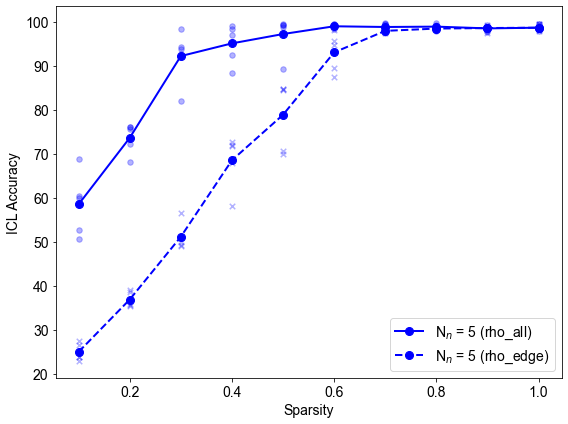

In [ ]:
seeds = [1,2,3,4,5]
nodes = [4,5,6]
nodes = [5]
sparsities = np.arange(0.1, 1.1, 0.1)

# Create a single figure with all data overlaid
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
fs = 14

# Define colors for each node
colors = ['blue', 'red', 'green']

# Define line styles for each dataset
linestyles = {'rho_all': '-', 'rho_edge': '--'}
labels_suffix = {'rho_all': ' (rho_all)', 'rho_edge': ' (rho_edge)'}

for idx, node in enumerate(nodes):
    # Process both rho_all and rho_edge datasets
    for dataset_type in ['rho_all', 'rho_edge']:
        # Dictionary to store accuracies for each sparsity across seeds
        sparsity_accuracies = {round(s, 1): [] for s in sparsities}
        
        for seed in seeds:
            for sparsity in sparsities:
                sparsity = round(sparsity, 1)
                if dataset_type == 'rho_all':
                    path = f"/Users/csfloyd/Dropbox/Projects/MarkovComputation/DirsICL/rho_all_seed_n_nodes{node}_2/{sparsity}_{seed}/"
                else:
                    path = f"/Users/csfloyd/Dropbox/Projects/MarkovComputation/DirsICL/rho_edge_seed_n_nodes{node}_2/{sparsity}_{seed}/"
                    
                
                results_path = path + "results.pkl"
                with open(results_path, "rb") as file:
                    data = pickle.load(file)

                # Extract components
                results = data['results']
                history = data['history']
                params = data['params']
                execution_time = data['execution_time']

                icl_acc = [val for val in history['icl_acc'] if val is not None][-1]
                
                sparsity_accuracies[sparsity].append(icl_acc)
                
                # Plot original data points
                marker = 'o' if dataset_type == 'rho_all' else 'x'
                ax.scatter(sparsity, icl_acc, color=colors[idx], alpha=0.3, s=30, marker=marker)
        
        # Compute moving average over seeds for each sparsity
        sparsity_list = sorted(sparsity_accuracies.keys())
        avg_accuracy_list = [np.mean(sparsity_accuracies[s]) for s in sparsity_list]
        
        # Plot line for this node and dataset type
        label = f'N$_n$ = {node}{labels_suffix[dataset_type]}'
        ax.plot(sparsity_list, avg_accuracy_list, marker='o', color=colors[idx], 
                label=label, linewidth=2, markersize=8, linestyle=linestyles[dataset_type])

ax.set_xlabel('Sparsity', fontsize=fs)
ax.set_ylabel('ICL Accuracy', fontsize=fs)
ax.tick_params(labelsize=fs)
#ax.grid(True, alpha=0.3)
ax.legend(fontsize=fs)

plt.tight_layout()
plt.show()

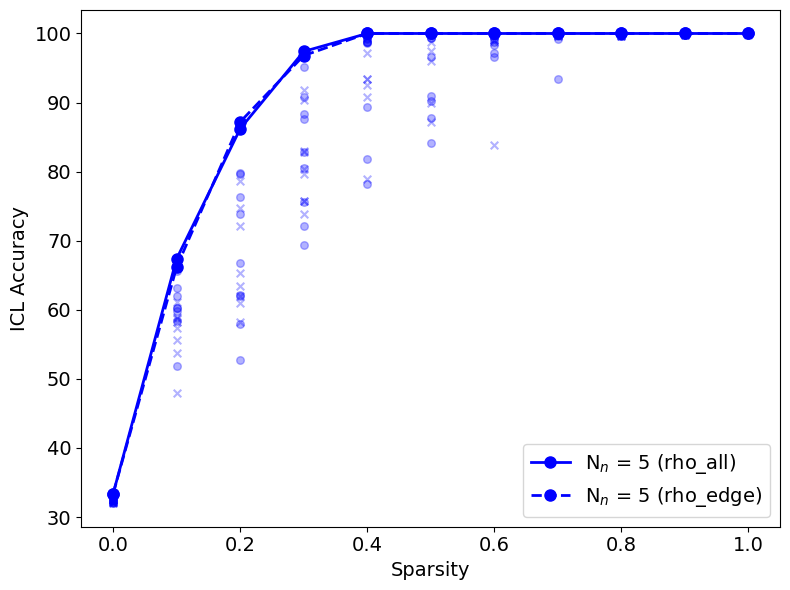

In [3]:
seeds = [1,2,3,4,5,6,7,8,9,10]
nodes = [4,5,6]
nodes = [5]
#sparsities = np.arange(0.2, 1.2, 0.2)
sparsities = np.arange(0.0, 1.1, 0.1)

# Create a single figure with all data overlaid
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
fs = 14

# Define colors for each node
colors = ['blue', 'red', 'green']

# Define line styles for each dataset
linestyles = {'rho_all': '-', 'rho_edge': '--'}
labels_suffix = {'rho_all': ' (rho_all)', 'rho_edge': ' (rho_edge)'}

for idx, node in enumerate(nodes):
    # Process both rho_all and rho_edge datasets
    for dataset_type in ['rho_all', 'rho_edge']:
        # Dictionary to store accuracies for each sparsity across seeds
        sparsity_accuracies = {round(s, 1): [] for s in sparsities}
        
        for seed in seeds:
            for sparsity in sparsities:
                sparsity = round(sparsity, 1)
                if dataset_type == 'rho_all':
                    path = f"/Users/csfloyd/Dropbox/Projects/MarkovComputation/DirsICL/rho_all_seed_n_nodes5_nlm0p0_big/{sparsity}_{seed}/"
                else:
                    path = f"/Users/csfloyd/Dropbox/Projects/MarkovComputation/DirsICL/rho_all_seed_n_nodes5_nlm0p2_big/{sparsity}_{seed}/"
                    
                
                try:
                    results_path = path + "results.pkl"
                    with open(results_path, "rb") as file:
                        data = pickle.load(file)
                except:
                    continue

                # Extract components
                results = data['results']
                history = data['history']
                params = data['params']
                execution_time = data['execution_time']

                icl_acc = [val for val in history['icl_acc'] if val is not None]
                if len(icl_acc) > 0:
                    #icl_acc = icl_acc[-1]
                    icl_acc = np.max(icl_acc)
                    sparsity_accuracies[sparsity].append(icl_acc)
                    
                    # Plot original data points
                    marker = 'o' if dataset_type == 'rho_all' else 'x'
                    ax.scatter(sparsity, icl_acc, color=colors[idx], alpha=0.3, s=30, marker=marker)
        
        # Compute moving average over seeds for each sparsity
        sparsity_list = sorted(sparsity_accuracies.keys())
        avg_accuracy_list = []
        for s in sparsity_list:
            if len(sparsity_accuracies[s]) > 0:
                avg_accuracy_list.append(np.max(sparsity_accuracies[s]))
            else:
                avg_accuracy_list.append(np.nan)
        
        # Plot line for this node and dataset type (only if we have data)
        if any(~np.isnan(avg_accuracy_list)):
            label = f'N$_n$ = {node}{labels_suffix[dataset_type]}'
            ax.plot(sparsity_list, avg_accuracy_list, marker='o', color=colors[idx], 
                    label=label, linewidth=2, markersize=8, linestyle=linestyles[dataset_type])

ax.set_xlabel('Sparsity', fontsize=fs)
ax.set_ylabel('ICL Accuracy', fontsize=fs)
ax.tick_params(labelsize=fs)
#ax.grid(True, alpha=0.3)
ax.legend(fontsize=fs)

plt.tight_layout()
plt.show()

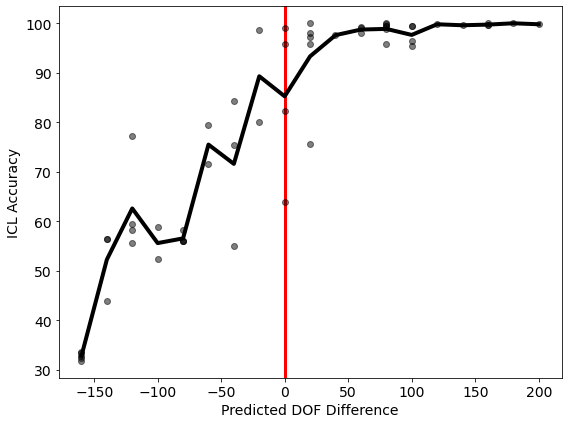

In [27]:
seed_array = [1, 2, 3, 4, 5]
sparsity_array = np.arange(0.0, 0.22, 0.02)
sparsity_array = [round(s,2) for s in sparsity_array]

needed_dof_list = []
available_dof_list = []
icl_accuracy_list = []
iwl_accuracy_list = []

for seed in seed_array:
    for sparsity in sparsity_array:
        path = f"/Users/csfloyd/Dropbox/Projects/MarkovComputation/DirsICL/rho_all_seed_n_nodes5_nlm_L_6/{sparsity}_{seed}/"
        results_path = path + "results.pkl"
        with open(results_path, "rb") as file:
            data = pickle.load(file)

        # Extract components
        results = data['results']
        history = data['history']
        params = data['params']
        execution_time = data['execution_time']

        needed_dof = 2 * params['D'] * params['N'] * (params['N']+1)
        model = load_model_nlm(params, path, print_creation=False)
        non_zero_count = non_zero_count = model.get_non_zero_count_L()

        needed_dof_list.append(needed_dof)
        available_dof_list.append(non_zero_count)

        icl_acc = [val for val in history['icl_acc'] if val is not None][-1]
        icl_acc = np.max([val for val in history['icl_acc'] if val is not None])
        iwl_acc = [val for val in history['iwl_acc'] if val is not None][-1]

        icl_accuracy_list.append(icl_acc)
        iwl_accuracy_list.append(iwl_acc)


dof_diff_list = np.array(available_dof_list) - np.array(needed_dof_list)

plt.figure(figsize=(8, 6))
fs = 14
# Sort both lists according to dof_diff_list order
sorted_indices = np.argsort(dof_diff_list)
sorted_dof_diff = np.array(dof_diff_list)[sorted_indices]
sorted_icl_accuracy = np.array(icl_accuracy_list)[sorted_indices]

# Compute running average
# window_size = 9
# running_avg_dof = []
# running_avg_icl = []
# for i in range(len(sorted_dof_diff) - window_size + 1):
#     running_avg_dof.append(np.mean(sorted_dof_diff[i:i+window_size]))
#     running_avg_icl.append(np.mean(sorted_icl_accuracy[i:i+window_size]))

unique_dof_diffs = list(sorted(set(sorted_dof_diff)))
running_avg_icl = []
for i in unique_dof_diffs:
    match_inds = np.where(sorted_dof_diff == i)[0]
    #running_avg_dof.append(np.mean(sorted_dof_diff[match_inds]))
    running_avg_icl.append(np.mean(sorted_icl_accuracy[match_inds]))

plt.scatter(dof_diff_list, icl_accuracy_list, label='ICL Accuracy', marker='o', color='black', alpha=0.5)
plt.plot(unique_dof_diffs, running_avg_icl, label='Running Average', color='black', linewidth=4)
#plt.scatter(dof_diff_list, iwl_accuracy_list, label='IWL Accuracy', marker='x')
plt.axvline(x=0, color='red', linestyle='-', linewidth=3, zorder=-10)
plt.xlabel('Predicted DOF Difference',fontsize=fs)
plt.ylabel('ICL Accuracy',fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.tight_layout()
plt.show()

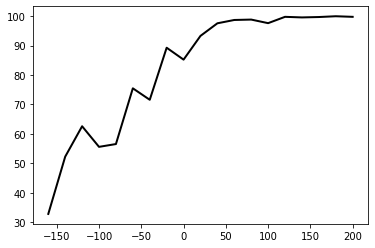

In [25]:
unique_dof_diffs = list(sorted(set(sorted_dof_diff)))
running_avg_icl = []
for i in unique_dof_diffs:
    match_inds = np.where(sorted_dof_diff == i)[0]
    #running_avg_dof.append(np.mean(sorted_dof_diff[match_inds]))
    running_avg_icl.append(np.mean(sorted_icl_accuracy[match_inds]))

#plt.scatter(unique_dof_diffs, icl_accuracy_list, label='ICL Accuracy', marker='o', color='black', alpha=0.5)
plt.plot(unique_dof_diffs, running_avg_icl, label='Running Average', color='black', linewidth=2)
